# Intro to Machine Learning 

In [10]:
# show the matplotlib plotted graph within notebook lines.
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [11]:
# import required libraries
# pandas:Data framework library for Python
# sklearn: Library to perform machine learning tasks
import os
import time
from tqdm import tqdm
import pandas as pd
import numpy as np
import scipy
import scipy.stats as st
import re
import codecs
from collections import Counter
import nltk
from nltk.stem import *
from nltk.corpus import stopwords
import sklearn 
import sklearn.datasets
import sklearn.metrics as metrics 
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import label_binarize
from scipy import stats

In [12]:
# extract data
#!tar -xf 20news-19997.tar.gz -C .
!tar -xf 20news-19997.tar

#!gzip -d -k 20news-19997.tar.gz

#!tar -xf 20news-19997.tar

In [13]:
# display newsgroups directories
!ls 20_newsgroups

alt.atheism              rec.autos                sci.space
comp.graphics            rec.motorcycles          soc.religion.christian
comp.os.ms-windows.misc  rec.sport.baseball       talk.politics.guns
comp.sys.ibm.pc.hardware rec.sport.hockey         talk.politics.mideast
comp.sys.mac.hardware    sci.crypt                talk.politics.misc
comp.windows.x           sci.electronics          talk.religion.misc
misc.forsale             sci.med


## Q1: Data Preprocessing and Initial Results

#### (a) How did you choose to construct your features? I.e., please specify the following: (i) the feature encoding method (hint: unigram, bigram, stem?, lowercase?), (ii) the method for ranking features, and (iii) your choice of how many features to select. Explain your rationale for each choice.

Feature construction:
 * feature encoding: unigram, lemmatize, remove stop wrods, term frequency
 * features were ranked by mutual information
 * top 1000 most frequent features selected for MI (reasonable number given computational limits), then 250 features selected. Initially 500, but minimal accuracy tradeoff.

#### (b) Write function dataPreprocessor:  data preprocessing settings (number of features, feature selection method, encoding method, and size of data) as input, and it should output a pandas Dataframe that contains preprocessed data where columns are features (except the last one, which is the target).

In [217]:
def dataPreprocessor(k, fs, encode, directorydf, size=None):
    """
    INPUT
        k: int. number of features to use
        fs: string. From ['tf', 'mi']
        encode: string. From ['tf', 'boolean']
        drectorydf: Dataframe. It is given, see above support functions
        size: int. Sample size. Default should be the data size.
    OUTPUT
        data: Dataframe. preprocessed data
    
    ps: 'tf' means term frequency, 'mi' means mutual information
    """
    
    ########### your code goes here ###########
    data = None
    
    #if fs == 'mi' and encode == 'tf':
    if fs == 'mi':


        
        #handle size
        wnLemm = WordNetLemmatizer()
        unfiltered_counter = Counter()
        for rownum, row in enumerate(directorydf.itertuples()):
            with codecs.open(row.Directories,"r" ,encoding='utf-8', errors='ignore') as myfile: 
                unfiltered_counter.update([wnLemm.lemmatize(word.lower(), 'v') for word in re.findall(r'\w+', myfile.read())]) 
                #for word in re.findall(r'\w+', myfile.read()):
                #    if nltk.corpus.wordnet.synsets(word) and len(word) > 2:
                #        unfiltered_counter.update([wnLemm.lemmatize(word.lower())])
        
        print(len(unfiltered_counter))
        
        #my_k = k + 200
        my_k = 1000
        
        if len(unfiltered_counter) < my_k:
            my_k = len(unfiltered_counter)
            
        filtered_set = {}
        for word, count in dict(unfiltered_counter.most_common(my_k)).items():
            #print(word)
            if word.isalpha() and word not in stopwords.words('english') and len(word) > 2:
                filtered_set[word] = count
                #print(word)
        
        #print(len(filtered_set))
        
        counter = Counter(dict(filtered_set))
        topk = counter.most_common()
        
        
        
        np = []
        # now that we have top k words, count the term frequecy of these words in individual file
        for rownum, row in enumerate(directorydf.itertuples()):
            with codecs.open(row.Directories,"r" ,encoding='utf-8', errors='ignore') as myfile:
                tempCounter = Counter([word for word in re.findall(r'\w+', myfile.read())])
                # if the word appears in the doc, then 1, else 
                if encode == 'tf':
                    topkinDoc = [tempCounter[word] for (word,wordCount) in topk]
                    # create a list for top k words with encoded target and its label
                    np.append(topkinDoc+[label_target(row.Directories)]+[row.Directories])
                else:
                    topkinDoc = [1 if tempCounter[word] > 0 else 0 for (word,wordCount) in topk]
                    np.append(topkinDoc+[label_target(row.Directories)]+[row.Directories])



                
        newsgroupdf = pd.DataFrame(np)
        dfName = []
        for c in topk:
            dfName.append(c[0])
            
        newsgroupdf.columns = dfName+['target','label']
        
        features_df = newsgroupdf[dfName]
        features = features_df.as_matrix()
        
        target_df = newsgroupdf[['target']]
        target = target_df.as_matrix()
        
        
        #following code adapted from: https://stackoverflow.com/questions/39839112/the-easiest-way-for-getting-feature-names-after-running-selectkbest-in-scikit-le
        selector = sklearn.feature_selection.SelectKBest(sklearn.feature_selection.mutual_info_classif, k)
        selector.fit(features, target)
        # Get idxs of columns to keep
        idxs_selected = selector.get_support(indices=True)
        # Create new dataframe with only desired columns, or overwrite existing
        features_dataframe_new = features[idxs_selected]
    
    
        final_set = {}
        for index in idxs_selected:
            final_set[dfName[index]] = newsgroupdf[dfName[index]]
        final_set['target'] = newsgroupdf['target']
        final_set['label'] = newsgroupdf['label']
        


        if size != None:
            data_total = pd.DataFrame(final_set)
            data_size = size/len(data_total)
            data = data_total.sample(axis=0, frac=data_size, replace=False)
        else:
            data = pd.DataFrame(final_set)


    

    ###########         end         ###########
    return data

In [221]:
data = dataPreprocessor(k=200, fs='mi', encode='tf', directorydf=directorydf, size=None)

#data = dataPreprocessor(k=50, fs='mi', encode='tf', directorydf=directorydf, size=None)

199898


/Users/shagun/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [222]:
data.head()

,abortion,access,advance,agree,alt,among,anything,apple,aramis,argument,...,version,video,war,way,win,window,windows,would,year,years
0,0,0,0,0,8,0,1,0,0,0,...,2,0,0,2,0,0,0,0,0,0
1,0,0,0,1,10,0,1,0,0,0,...,0,0,0,13,0,0,0,7,0,2
2,0,0,0,0,1,0,0,0,0,3,...,0,0,0,1,0,0,0,4,0,0
3,0,0,0,0,4,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [95]:

data.to_csv('top500-wordnetmod.csv')



In [99]:
test = ['hello', 'my', 'name', 'x', 'austin']
for word in test:
    if nltk.corpus.wordnet.synsets(word):
        print (word)

hello
name
x
austin


#### (c) For ten trials of randomized train/test splits, report the training accuracy and test accuracy of each trial as well as the average and 95% confidence intervals. What do you observe about their comparison and why?

In [155]:
def randomSplitCI(data, clf, num_run, **params):
    """
    INPUT
        data: 2D numpy array. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
        num_run: int. How many times you want to run for random evaluation?
        params: string->real. Hyper-parameter of classifier. PS: c=1.0, r=0.01
    
    OUTPUT
        train_scores: list. Results of trials
        test_scores: list. Results of trials
        train_mean: scalar. Average accuracy
        test_mean: scalar. Average accuracy
        train_ci: scalar. Confidence Interval
        test_ci: scalar. Confidence Interval
    """
    
    ########### your code goes here ###########

    features = data.drop(['label', 'target'], axis=1).as_matrix()

    target = data[['target']].as_matrix()
    
    train_scores = []
    test_scores = []
    train_mean = 0
    test_mean = 0
    
    train_ci = 0
    test_ci = 0
    
    if (clf == 'LR'):
        clfFn = LogisticRegression(C=params["c"])
    elif (clf == 'NB'):
        clfFn = GaussianNB()
    else:
        return
    
    for i in range(num_run):
        # x_train,      x_test,        y_train,      y_test
        features_train, features_test, target_train, target_test = train_test_split(features, target, stratify=target, test_size=0.3)
        # train_features, test_features, target_train, target_test = train_test_split(features, target, test_size=0.3)
    
        # train the features and target datasets and fit to a model
        clfModel = clfFn.fit(features_train, target_train)

        # predict target with feature test set using trained model
        target_pred = clfModel.predict(features_test)
        
        # predict target with feature train test set using trained model
        feature_pred = clfModel.predict(features_train)
        
        train_scores.append(metrics.accuracy_score(target_train, feature_pred))
        test_scores.append(metrics.accuracy_score(target_test, target_pred))
        
    train_mean = np.mean(train_scores)
    test_mean = np.mean(test_scores)
    
    train_ci_full = st.t.interval(0.95, len(train_scores)-1, loc=train_mean, scale = st.sem(train_scores))
    test_ci_full = st.t.interval(0.95, len(test_scores)-1, loc=test_mean, scale = st.sem(test_scores))

    train_ci = train_mean - train_ci_full[0]
    test_ci = test_mean - test_ci_full[0]

    
    ###########         end         ###########
    return train_scores,test_scores,train_mean,test_mean,train_ci,test_ci 

In [223]:
train_scores,test_scores,train_mean,test_mean,train_ci,test_ci = randomSplitCI(data, 'LR', 10, c=1.0)
print("Train\
    \nResult of trails:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}\n".format(train_scores, train_mean, train_ci)
     )
print("Test\
    \nResult of trails:{0} \
    \nAverage Accuracy: {1} \
    \nConfidence Interval: {2}".format(test_scores, test_mean, test_ci)
     )

/Users/shagun/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Train    
Result of trails:[0.96384939629920696, 0.96527827391583909, 0.96406372794170181, 0.96434950346502823, 0.96506394227334424, 0.96327784525255411, 0.96242051868257483, 0.96377795241837538, 0.96334928913338569, 0.96349217689504896]     
Average Accuracy: 0.9638922626277058     
Confidence Interval: 0.0006100680927253466

Test    
Result of trails:[0.94999999999999996, 0.94350000000000001, 0.94599999999999995, 0.94933333333333336, 0.94466666666666665, 0.94933333333333336, 0.95266666666666666, 0.94899999999999995, 0.95116666666666672, 0.94783333333333331]     
Average Accuracy: 0.9483500000000001     
Confidence Interval: 0.0020585077754199377


For LR
Train    
Result of trails:[0.96527827391583909, 0.96434950346502823, 0.96520683003500751, 0.96384939629920696, 0.96484961063084951, 0.96277773808673284, 0.96420661570336497, 0.96320640137172253, 0.96320640137172253, 0.96313495749089095]     
Average Accuracy: 0.9640065728370365     
Confidence Interval: 0.0006530796155977958

Test    
Result of trails:[0.94733333333333336, 0.94933333333333336, 0.94416666666666671, 0.94316666666666671, 0.94699999999999995, 0.94850000000000001, 0.94833333333333336, 0.94516666666666671, 0.94550000000000001, 0.94899999999999995]     
Average Accuracy: 0.94675     
Confidence Interval: 0.001532260922333717

For NB
Train    
Result of trails:[0.59191255268986209, 0.60398656855040367, 0.57748088876187753, 0.56726441380295778, 0.56554976066299922, 0.58712581267414443, 0.58598271058083873, 0.58784025148246055, 0.5671929699221262, 0.55740515824819603]     
Average Accuracy: 0.5791741087375866     
Confidence Interval: 0.010422248985307192

Test    
Result of trails:[0.5665, 0.5718333333333333, 0.55000000000000004, 0.54149999999999998, 0.54216666666666669, 0.5658333333333333, 0.55233333333333334, 0.55649999999999999, 0.53766666666666663, 0.52449999999999997]     
Average Accuracy: 0.5508833333333334     
Confidence Interval: 0.010598400861842161

Training accuracy and confidence interval is better than the test accuracy and confidence interval. This is expected given that the model is fit to the training data.

#### (d) What do the average and 95% confidence intervals tell you? Are they more informative than a single trial? Yes or no, and why?

A 95% confidence interval is a range of values that you can be 95% certain contains the true mean of the sample (level of certainty of the true mean). They are more informative than a single trial because a 95% confidence interval implies that if same data were to be sampled on numerous occasions and interval estimates are made on each occasion, the resulting intervals would bracket the true mean in approximately 95 % of the cases. 

#### (e) For multiclass only: compute the confusion matrix by filling up Function randomSplitCM.

In [163]:
def randomSplitCM(data, clf, num_run, **params):
    """
    INPUT
        data: Dataframe. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
        params: string->real. Hyper-parameter of classifier. PS: c=1.0, r=0.01
    
    OUTPUT
        cm: pandas.DataFrame. Confusion Matrix
    """
    
    ########### your code goes here ###########
    
    
    features = data.drop(['label', 'target'], axis=1).as_matrix()

    target = data[['target']].as_matrix()

    cms = {}
        
    labels = data['target'].unique()


    if (clf == 'LR'):
        clfFn = LogisticRegression(C=params["c"])
    elif (clf == 'NB'):
        clfFn = GaussianNB()
    else:
        return

    for i in range(num_run):
        # x_train,      x_test,        y_train,      y_test
        features_train, features_test, target_train, target_test = train_test_split(features, target, stratify=target, test_size=0.3)


        # train the features and target datasets and fit to a model
        clfModel = clfFn.fit(features_train, target_train)

        # predict target with feature test set using trained model
        target_pred = clfModel.predict(features_test)

        # predict target with feature train test set using trained model
        feature_pred = clfModel.predict(features_train)
            
        cms[i] = pd.DataFrame(metrics.confusion_matrix(target_test, target_pred), columns=labels, index=labels)



    # Panel of all test set confusion matrices
    pl = pd.Panel(cms)
    cm = pl.sum(axis=0) #Sum the confusion matrices to get one view of how well the classifiers perform
    
    ###########         end         ###########
    return cm

In [193]:
cm = randomSplitCM(data, 'LR', 10, c=1.0)

/Users/shagun/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/shagun/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  """Entry point for launching an IPython kernel.


#### (f) For multiclass only: show the confusion matrix (or a subset if too large to view at once). Are some classes more easily confused with others? Which ones and why?

In [165]:
cm

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,2445,0,0,0,8,0,0,0,4,0,0,4,0,0,0,0,2,2,0,535
1,0,2859,24,23,4,47,3,0,1,0,0,0,4,29,5,0,0,0,1,0
2,0,27,2912,26,0,23,2,0,0,0,0,0,0,6,4,0,0,0,0,0
3,0,16,21,2900,27,20,6,0,0,0,0,0,6,0,4,0,0,0,0,0
4,0,10,0,49,2926,0,8,1,0,0,0,0,5,1,0,0,0,0,0,0
5,0,70,108,38,0,2759,3,0,1,0,0,1,5,9,6,0,0,0,0,0
6,0,9,2,17,11,0,2934,9,10,1,0,0,7,0,0,0,0,0,0,0
7,0,0,2,0,0,0,10,2966,4,2,0,0,16,0,0,0,0,0,0,0
8,0,0,0,0,8,0,14,8,2950,8,0,0,0,4,3,0,5,0,0,0
9,0,0,0,0,0,0,0,0,0,2984,16,0,0,0,0,0,0,0,0,0


Class 0 and Class 19 are easily confused with one another because they are similar topics - "athesim" vs "religion" - therefore the terms in those classes are likely to be similar.
Classes with more unique classes such as class 11 (crypt) are less likely to be confused with others

## Q2: Performance vs. # Features Selected

#### (a) Write a function featureSizeAC which takes preprocessed data and classifier name as input, and outputs train and test accuracy for each of the feature size settings (k ∈ {10%, 20%, ..., 90%, 100%}).

In [166]:
def featureSizeAC(data, clf, num_run, **params):
    """
    INPUT
        data: Dataframe. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
        params: string->real. Hyper-parameter of classifier. PS: c=1.0, r=0.01
    
    OUTPUT
        train_mean_fs: list.
        train_ci_fs: list.
        test_mean_fs: list.
        test_ci_fs: list.
        
    """
    feature_precentage = np.linspace(0.1, 1, 10, endpoint=True)
    ########### your code goes here ###########
    

    #create features dataframe from data by dropping label and target coloums
    features_set = data.drop(['label', 'target'], axis=1)
    
    #confirm shape of features_set dataframe
    #print (features_set.shape)    
    
    target = data[['target']].as_matrix()

    train_scores_fs = []
    test_scores_fs = []
    temp_train_mean = 0
    temp_test_mean = 0
    train_mean_fs = []
    test_mean_fs = []
    temp_train_ci = 0
    temp_test_ci = 0
    train_ci_fs = []
    test_ci_fs = []
        

    if (clf == 'LR'):
        clfFn = LogisticRegression(C=params["c"])
    elif (clf == 'NB'):
        clfFn = GaussianNB()
    else:
        return
    
    #iterate through feature size 10%, 20%, 30%... 
    for percentage in feature_precentage:
        
        #select a random sample of x% of features from features data frame, where x = percentage 
        #reference: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sample.html
        features = features_set.sample(axis=1, frac=percentage, replace=False).as_matrix() 
        
        train_scores_fs = []
        test_scores_fs =[]
        
        #run num_run trials for the selected feature size
        for i in range(num_run):
            # x_train,      x_test,        y_train,      y_test
            features_train, features_test, target_train, target_test = train_test_split(features, target, stratify=target, test_size=0.3)
            # train the features and target datasets and fit to a model
            clfModel = clfFn.fit(features_train, target_train)

            # predict target with feature test set using trained model
            target_pred = clfModel.predict(features_test)

            # predict target with feature train test set using trained model
            feature_pred = clfModel.predict(features_train)
        
            #build an array conatining test and training scores for each run of the selected sample size
            train_scores_fs.append(metrics.accuracy_score(target_train, feature_pred))
            test_scores_fs.append(metrics.accuracy_score(target_test, target_pred))
        
        
        temp_train_mean = np.mean(train_scores_fs)
        temp_test_mean = np.mean(test_scores_fs)
        
        train_mean_fs.append(temp_train_mean)
        test_mean_fs.append(temp_test_mean)
        
        temp_train_ci = st.t.interval(0.95, len(train_scores_fs)-1, loc=temp_train_mean, scale = st.sem(train_scores_fs))
        temp_test_ci = st.t.interval(0.95, len(test_scores_fs)-1, loc=temp_test_mean, scale = st.sem(test_scores_fs))
        
        train_ci_fs.append(temp_train_mean - temp_train_ci[0])
        test_ci_fs.append(temp_test_mean - temp_test_ci[0])    
    
    
    ###########         end         ###########
    return train_mean_fs, train_ci_fs, test_mean_fs, test_ci_fs

In [167]:
train_mean_fs, train_ci_fs, test_mean_fs, test_ci_fs = featureSizeAC(data, 'LR', 10, c=1.0, r=0.7)

/Users/shagun/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### (b) use your code to produce a plot with the train accuracy (blue) and test accuracy (red) as a function of the number of features selected (10%, 20%, ..., 90%, 100%). Explain any trends you see (average over multiple trials if trends are not clear).

In [168]:
def featureSizePlot(feature_size, train_mean_fs, train_ci_fs, test_mean_fs, test_ci_fs):
    # First illustrate basic pyplot interface, using defaults where possible.
    plt.figure()
    test_curve=plt.errorbar(feature_size, test_mean_fs, color=sns.xkcd_rgb["pale red"], yerr=test_ci_fs)
    train_curve=plt.errorbar(feature_size, train_mean_fs,color=sns.xkcd_rgb["denim blue"], yerr=train_ci_fs)
    plt.legend([test_curve, train_curve], ['Test', 'Train'])
    plt.xlabel('Feature Percentage')
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs Feature Size")
    plt.show()

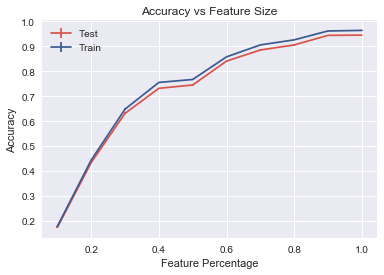

In [196]:
featureSizePlot(np.linspace(0.1, 1, 10, endpoint=True),train_mean_fs, train_ci_fs, test_mean_fs, test_ci_fs )

Accuracy increaes are more features are used. This makes sense given that initial k features were picked for maximum accuracy - fewer features = lesser distrciminating power.

### Q3: Hyperparameter Tuning

#### a) Write a function hyperparameterAC which takes preprocessed data and a classifier name as input, and outputs train and test accuracy for each of the hyperparameter settings (C ∈ {10−4, 10−3, ..., 100,... 103, 104}).

In [199]:
def hyperParameterAC(data, clf, num_run):
    """
    INPUT
        data: Dataframe. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
    
    OUTPUT
        test_mean_hp: list.  mean accuracy list of test
        test_ci_hp: list. confidence interval list of test
        train_mean_hp: list. mean accuracy list of train
        train_ci_hp: list. confidence interval list of train
        
    NOTE 
        randomSplitCI could be the sub-route of this function
    """
    params = np.logspace(-4, 4, num=9)
    
    ########### your code goes here ###########

    #create features array from data, also drop label and target coloums
    features = data.drop(['label', 'target'], axis=1).as_matrix()

    target = data[['target']].as_matrix()

    train_scores_hp = []
    test_scores_hp = []
    temp_train_mean = 0
    temp_test_mean = 0
    train_mean_hp = []
    test_mean_hp = []
    temp_train_ci = 0
    temp_test_ci = 0
    train_ci_hp = []
    test_ci_hp = []
        

    if (clf != 'LR'):
        return
    
    #iterate through each hyperparameter setting 
    for c in params:
        clfFn = LogisticRegression(C=c)
        
        train_scores_hp = []
        test_scores_hp =[]
                
        for i in range(num_run):
            # x_train,      x_test,        y_train,      y_test
            features_train, features_test, target_train, target_test = train_test_split(features, target, stratify=target, test_size=0.3)
            # train the features and target datasets and fit to a model
            clfModel = clfFn.fit(features_train, target_train)

            # predict target with feature test set using trained model
            target_pred = clfModel.predict(features_test)

            # predict target with feature train test set using trained model
            feature_pred = clfModel.predict(features_train)
        
            train_scores_hp.append(metrics.accuracy_score(target_train, feature_pred))
            test_scores_hp.append(metrics.accuracy_score(target_test, target_pred))
        
        temp_train_mean = np.mean(train_scores_hp)
        temp_test_mean = np.mean(test_scores_hp)
        
        train_mean_hp.append(temp_train_mean)
        test_mean_hp.append(temp_test_mean)
                
        temp_train_ci = st.t.interval(0.95, len(train_scores_hp)-1, loc=temp_train_mean, scale = st.sem(train_scores_hp))
        temp_test_ci = st.t.interval(0.95, len(test_scores_hp)-1, loc=temp_test_mean, scale = st.sem(test_scores_hp))
        
        train_ci_hp.append(temp_train_mean - temp_train_ci[0])
        test_ci_hp.append(temp_test_mean - temp_test_ci[0])
    
    
    
    
    ###########         end         ###########
    return train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp

In [200]:
train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp = hyperParameterAC(data, 'LR', 5)

/Users/shagun/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### b) Now that you’ve implemented hyperparameterAC, use the code following it to plot train accuracy (blue) and test accuracy (red) as a function of the hyperparameter setting (10−4, 10−3, ..., 100,... 103, 104). Use a logarithmic x-axis. Explain any trends you see (average over multiple trials if trends are not clear). 

In [201]:
def hyperParameterPlot(params, train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp):
    # First illustrate basic pyplot interface, using defaults where possible.
    plt.figure()
    test_curve=plt.errorbar(params, test_mean_hp, color=sns.xkcd_rgb["pale red"], yerr=test_ci_hp)
    train_curve=plt.errorbar(params, train_mean_hp,color=sns.xkcd_rgb["denim blue"], yerr=train_ci_hp)
    plt.legend([test_curve, train_curve], ['Test', 'Train'])
    plt.xlabel('Parameter')
    plt.xscale("log")
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs Parameters")
    plt.show()

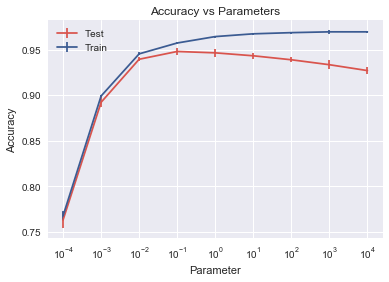

In [202]:
hyperParameterPlot(np.logspace(-4, 4, num=9),train_mean_hp, train_ci_hp, test_mean_hp, test_ci_hp )

C is inverse regularization strength - smaller values specify stronger regularization.
If regularlization is too strong (small hyperparameter value) accuracy decreases because model is not able to fit data. If regularization is too weak, the model will overfit the data - as a result, training data will perform well but test data will not.

## Q4

#### (a) Write a function dataSizeAC which takes preprocessed data and classifier name as input, and outputs train and test accuracy for each of the training data size settings (size ∈ {10%, 20%, ..., 90%, 100%}).

In [203]:
def dataSizeAC(data, clf, num_run):
    """
    INPUT
        data: Dataframe. Pre-processed data
        clf: string. Name of the classifier from ['LR', 'SVM', 'NB']
        params: string->real. Hyper-parameter of classifier. PS: c=1.0, r=0.01
    
    OUTPUT
        test_mean_ds: list.  mean accuracy list of test
        test_ci_ds: list. confidence interval list of test
        train_mean_ds: list. mean accuracy list of train
        train_ci_ds: list. confidence interval list of train
        
        
        
    NOTE 
        randomSplitCI could be the sub-route of this function
    """
    data_precentage = np.linspace(0.1, 1, 10, endpoint=True)
    
    ########### your code goes here ###########

    #create features array from data, also drop label and target coloums
    features = data.drop(['label', 'target'], axis=1).as_matrix()

    target = data[['target']].as_matrix()
    
    if (clf == 'LR'):
        clfFn = LogisticRegression()
    elif (clf == 'NB'):
        clfFn = GaussianNB()
    else:
        return
    
    temp_train_scores = []
    temp_test_scores = []
    train_scores_ds = np.empty((0, 10))
    test_scores_ds = np.empty((0, 10))
    temp_train_mean = []
    temp_test_mean = []
    train_mean_ds = []
    test_mean_ds = []
    temp_train_ci = 0
    temp_test_ci = 0
    train_ci_ds = []
    test_ci_ds = []
    
    for i in range(num_run):
        
        # x_train,            x_test,        y_train,            y_test
        features_train_trial, features_test, target_train_trial, target_test = train_test_split(features, target, stratify=target, test_size=0.3)
        
        #print ('trial', i)
        #print ('shape of initial split - training', features_train_trial.shape)
        
        temp_train_scores = []
        temp_test_scores = []
        
        
        for percentage in data_precentage:
            if percentage < 1.0:
                training_percent =  percentage #.7 *
                # x_train,      x_test, y_train,      y_test
                features_train, _,      target_train, _ = train_test_split(features_train_trial, target_train_trial, test_size=0.0, train_size = training_percent)
            else:
                # x_train,      x_test, y_train,      y_test
                features_train, _,      target_train, _ = train_test_split(features_train_trial, target_train_trial, test_size=0.0)
           
            # train the features and target datasets and fit to a model
            clfModel = clfFn.fit(features_train, target_train)

            # predict target with feature test set using trained model
            target_pred = clfModel.predict(features_test)

            # predict target with feature train test set using trained model
            feature_pred = clfModel.predict(features_train)
            
            temp_train_scores.append(metrics.accuracy_score(target_train, feature_pred))
            temp_test_scores.append(metrics.accuracy_score(target_test, target_pred))
        
        train_scores_ds = np.append(train_scores_ds, [temp_train_scores], axis=0)
        test_scores_ds = np.append(test_scores_ds, [temp_test_scores], axis=0)
        #print('train_scores_ds           :, train_scores_ds)
    
    train_mean_ds = np.mean(train_scores_ds, axis=0).tolist()
    test_mean_ds = np.mean(test_scores_ds, axis=0).tolist()
    #print ('all mean scores', train_mean_ds)

    #ci_train_score = np.transpose(train_scores_ds)
    #print (ci_train_score)
    #print ('this is row 1', ci_train_score[0,:])
    
    #ci_train_score = []
    #ci_test_score = []
    
    
    

    for score in range(10):
        ci_train_score = np.transpose(train_scores_ds[:,score])
        temp_train_mean = train_mean_ds[score]
        temp_train_ci = st.t.interval(0.95, len(ci_train_score)-1, loc=temp_train_mean, scale = st.sem(ci_train_score))
        train_ci_ds.append(temp_train_mean - temp_train_ci[0])
        
    for score in range(10):
        ci_test_score = np.transpose(test_scores_ds[:,score])
        temp_test_mean = test_mean_ds[score]
        temp_test_ci = st.t.interval(0.95, len(ci_test_score)-1, loc=temp_test_mean, scale = st.sem(ci_test_score))
        test_ci_ds.append(temp_test_mean - temp_test_ci[0])
        

    ###########         end         ###########
    return train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds

In [204]:
train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds = dataSizeAC(data, 'LR', 5)

/Users/shagun/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### (b) Now that you’ve implemented dataSizeAC, use the code following it to plot train accuracy (blue) and test accuracy (red) as a function of the amount of train data (10%, 20%, ..., 90%, 100%) while holding the amount of test data fixed. Explain any trends you see.

In [205]:
def dataSizePlot(datasize, train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds):
    # First illustrate basic pyplot interface, using defaults where possible.
    plt.figure()
    test_curve=plt.errorbar(datasize, test_mean_ds, color=sns.xkcd_rgb["pale red"], yerr=test_ci_ds)
    train_curve=plt.errorbar(datasize, train_mean_ds,color=sns.xkcd_rgb["denim blue"], yerr=train_ci_ds)
    plt.legend([test_curve, train_curve], ['Test', 'Train'])
    plt.xlabel('Data Percentage')
    plt.ylabel('Accuracy')
    plt.title("Accuracy vs Data Percentage")
    plt.show()

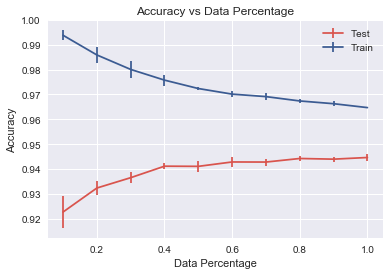

In [206]:
dataSizePlot(np.linspace(0.1, 1, 10, endpoint=True),train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds)

Data size doesnt affect training data as much since the model is able to fit the data well. However, small data size does not allow the model to generalize well to the test set.

## Q5: Performance vs. Feature Encoding

#### (a) Show the vectors representing the binary and TF encodings of one of the data files.

In [207]:
#data.loc[1]
#print('ss')

print('File:', data.loc[1]['label'])
data.drop(['label', 'target'], axis=1).loc[1].as_matrix()


File: 20_newsgroups/alt.atheism/51060


array([ 0,  1,  0,  0,  1,  6, 10,  0,  0,  0,  0,  6, 49,  0,  0,  0,  0,
        0, 25,  0,  0,  0,  2,  0,  0,  2,  0,  0,  4,  0,  1,  0,  4,  2,
        0,  1,  0,  0,  0,  2,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,
        5,  0,  0,  0, 18,  3,  6,  4,  5,  0,  1,  0,  0,  0,  0,  2,  0,
        0,  1,  1,  0,  0,  0,  0,  0,  0,  1,  0,  7,  0,  3,  0,  0,  0,
        5,  0,  0,  1,  0, 11,  0,  0,  1,  0,  0, 26,  5, 19,  0,  0,  0,
        0,  0,  6,  0,  1,  0,  8,  7,  0, 14,  1,  0,  3,  0,  0, 17,  0,
        0,  0, 21,  8,  0,  0,  1,  0,  2,  0,  2,  1,  0,  0,  2,  0,  1,
        0, 23, 42,  0,  1,  0,  0,  0,  0, 11,  0,  4,  0,  0,  6,  0,  0,
        1,  0,  2,  5,  0,  0,  0,  0,  0,  0,  0,  3,  9,  0,  0,  0,  0,
        1,  0,  2,  4,  2,  0, 10,  5,  0,  0,  0,  1,  0,  6,  0,  0,  0,
        0,  5,  2,  0,  0,  0,  0,  3,  5,  7,  0,  0,  2])

In [208]:

print('File:', data.loc[1]['label'])
features_mod = data.drop(['label', 'target'], axis=1).loc[1].as_matrix()

for i in range(len(features_mod)):
    features_mod[i] = 1 if features_mod[i] > 0 else 0
        
print(features_mod)

       

File: 20_newsgroups/alt.atheism/51060
[0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0
 0 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0
 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 1 0 1 0 1 1 0
 1 1 0 1 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 0 0 1 0 1
 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 0 1 0 1 0
 0 0 0 1 1 0 0 0 0 1 1 1 0 0 1]


#### (b) Run enough trials to obtain non-overlapping 95% CIs on the average accuracy of each feature encoding method (binary and TF). Which feature encoding method performs better on this dataset? Why do you think this occurs? 

You should be able to get this answer easily by running dataPreprocessor fuction and randomSplitCI function

TF does a lot better than Boolean encoding. This makes sense as it weights more frequent terms (likely to have more discriminating power) more highly.


For TF
Train    
Result of trails:[0.96892191183825105, 0.97006501393155675, 0.96970779452739875, 0.97056512109737803, 0.9691362434807459, 0.97020790169322002, 0.96992212616989359, 0.96970779452739875, 0.97085089662070445, 0.96935057512324074]     
Average Accuracy: 0.9698435379009787     
Confidence Interval: 0.0004366326298835821

Test    
Result of trails:[0.95350000000000001, 0.94783333333333331, 0.95083333333333331, 0.94950000000000001, 0.95399999999999996, 0.94933333333333336, 0.95299999999999996, 0.95233333333333337, 0.94799999999999995, 0.95133333333333336]     
Average Accuracy: 0.9509666666666667     
Confidence Interval: 0.0016033343964252378

BLN
Train    
Result of trails:[0.96527827391583909, 0.96434950346502823, 0.96520683003500751, 0.96384939629920696, 0.96484961063084951, 0.96277773808673284, 0.96420661570336497, 0.96320640137172253, 0.96320640137172253, 0.96313495749089095]     
Average Accuracy: 0.9640065728370365     
Confidence Interval: 0.0006530796155977958

Test    
Result of trails:[0.94733333333333336, 0.94933333333333336, 0.94416666666666671, 0.94316666666666671, 0.94699999999999995, 0.94850000000000001, 0.94833333333333336, 0.94516666666666671, 0.94550000000000001, 0.94899999999999995]     
Average Accuracy: 0.94675     
Confidence Interval: 0.001532260922333717

## Q6: Comparison vs. Naive Bayes

#### (a) Run enough trials to obtain non-overlapping 95% CIs on the average accuracy of logistic regression vs. Naive Bayes classifiers.  Which classification algorithm performs better on this dataset? Why do you think this occurs?

LR does better than NB. Logistic Regression directly estimates the parameters of P(Y|X) (discriminative classifier) whereas Naive Bayes directly estimates parameters for P(Y) and P(X|Y) (generative).

Logistic Regression is a linear classifier over X. The linear classifiers produced by Logistic Regression and Gaussian Naive Bayes are identical provided the Naive Bayes assumptions hold. However, if these assumptions do not hold, the Naive Bayes bias will cause it to perform less accurately than LR, in the limit. Put another way, Naive Bayes is a learning algorithm with greater bias, but lower variance, than Logistic Regression. If this bias is appropriate given the actual data, Naive Bayes will be preferred. Otherwise, Logistic Regression will be preferred.

### LR
**Train**    
- Result of trails:[0.96527827391583909, 0.96434950346502823, 0.96520683003500751, 0.96384939629920696, 0.96484961063084951, 0.96277773808673284, 0.96420661570336497, 0.96320640137172253, 0.96320640137172253, 0.96313495749089095]     
- Average Accuracy: 0.9640065728370365     
- Confidence Interval: 0.0006530796155977958

**Test**    
- Result of trails:[0.94733333333333336, 0.94933333333333336, 0.94416666666666671, 0.94316666666666671, 0.94699999999999995, 0.94850000000000001, 0.94833333333333336, 0.94516666666666671, 0.94550000000000001, 0.94899999999999995]     
- Average Accuracy: 0.94675     
- Confidence Interval: 0.001532260922333717


### NB
**Train**    
- Result of trails:[0.59191255268986209, 0.60398656855040367, 0.57748088876187753, 0.56726441380295778, 0.56554976066299922, 0.58712581267414443, 0.58598271058083873, 0.58784025148246055, 0.5671929699221262, 0.55740515824819603]     
- Average Accuracy: 0.5791741087375866     
- Confidence Interval: 0.010422248985307192

**Test**    
- Result of trails:[0.5665, 0.5718333333333333, 0.55000000000000004, 0.54149999999999998, 0.54216666666666669, 0.5658333333333333, 0.55233333333333334, 0.55649999999999999, 0.53766666666666663, 0.52449999999999997]     
- Average Accuracy: 0.5508833333333334     
- Confidence Interval: 0.010598400861842161




## Support functions

In [14]:
def getFilesDirectory(datapath='20_newsgroups'):
    # create file directory for all files
    files = []
    for (path, dirnames, filenames) in os.walk(datapath):
        files.extend(os.path.join(path, name) for name in filenames)
    # putting file directories into pandas dataframe
    directorydf= pd.DataFrame(files)
    directorydf.columns = ['Directories']
    return directorydf

In [15]:
directorydf = getFilesDirectory()

In [16]:
# create function to help encoding the targets
def label_target (d):
    if d.find("alt.atheism") > 0 :
      return 0
    if d.find("comp.graphics") > 0:
      return 1
    if d.find("comp.os.ms-windows.misc") > 0:
      return 2
    if d.find("comp.sys.ibm.pc.hardware") > 0:
      return 3
    if d.find("comp.sys.mac.hardware") > 0:
      return 4
    if d.find("comp.windows.x") > 0:
      return 5
    if d.find("misc.forsale") > 0:
      return 6
    if d.find("rec.autos") > 0:
      return 7
    if d.find("rec.motorcycles") > 0:
      return 8
    if d.find("rec.sport.baseball") > 0:
      return 9
    if d.find("rec.sport.hockey") > 0:
      return 10
    if d.find("sci.crypt") > 0:
      return 11
    if d.find("sci.electronics") > 0:
      return 12
    if d.find("sci.med") > 0:
      return 13
    if d.find("sci.space") > 0:
      return 14
    if d.find("soc.religion.christian") > 0:
      return 15
    if d.find("talk.politics.guns") > 0:
      return 16
    if d.find("talk.politics.mideast") > 0:
      return 17
    if d.find("talk.politics.misc") > 0:
      return 18
    if d.find("talk.religion.misc") > 0:
      return 19
    return 'Other'

### Code Validation

In [ ]:
# dataPreprocessor
assert(isinstance(data, pd.DataFrame)), "data should be pandas dataframe type"

In [ ]:
#randomSplitCI
assert(isinstance(train_scores, list)), "train_scores should be list type"
assert(isinstance(test_scores, list)), "test_scores should be list type"
assert(isinstance(train_mean, float)), "train_mean should be float type"
assert(isinstance(test_mean, float)), "test_mean should be float type"
assert(isinstance(train_ci, float)), "train_ci should be float type"
assert(isinstance(test_ci, float)), "test_ci should be float type"

In [ ]:
#randomSplitCM
assert(isinstance(cm, pd.DataFrame)), "Confusion matrix should be pandas dataframe type"

In [ ]:
#featureSizeAC
assert(isinstance(train_mean_fs, list)), "train_mean_fs should be list type"
assert(isinstance(test_mean_fs, list)), "test_mean_fs should be list type"
assert(isinstance(train_ci_fs, list)), "train_ci_fs should be list type"
assert(isinstance(test_ci_fs, list)), "test_ci_fs should be list type"
assert(len(train_mean_fs)==len(train_ci_fs)), \
"list length of mean and confidence interval are not equal(train)"
assert(len(test_mean_fs)==len(test_ci_fs)), \
"list length of mean and confidence interval are not equal(test)"

In [ ]:
#hyperParameterAC
assert(isinstance(train_mean_hp, list)), "train_mean_hp should be list type"
assert(isinstance(test_mean_hp, list)), "test_mean_hp should be list type"
assert(isinstance(train_ci_hp, list)), "train_ci_hp should be list type"
assert(isinstance(test_ci_hp, list)), "test_ci_hp should be list type"
assert(len(train_mean_hp)==len(train_ci_hp)), \
"list length of mean and confidence interval are not equal(train)"
assert(len(test_mean_hp)==len(test_ci_hp)), \
"list length of mean and confidence interval are not equal(test)"

In [ ]:
#dataSizeAC
train_mean_ds, train_ci_ds, test_mean_ds, test_ci_ds
assert(isinstance(train_mean_ds, list)), "train_mean_ds should be list type"
assert(isinstance(test_mean_ds, list)), "test_mean_ds should be list type"
assert(isinstance(train_ci_ds, list)), "train_ci_ds should be list type"
assert(isinstance(test_ci_ds, list)), "test_ci_ds should be list type"
assert(len(train_mean_ds)==len(train_ci_ds)), \
"list length of mean and confidence interval are not equal(train)"
assert(len(test_mean_ds)==len(test_ci_ds)), \
"list length of mean and confidence interval are not equal(test)"